In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import skew, kurtosis
from statsmodels.stats.diagnostic import het_breuschpagan, het_white, acorr_breusch_godfrey
from statsmodels.stats.stattools import durbin_watson
from linearmodels.iv import IV2SLS
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Configuration des graphiques
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
np.random.seed(42)

In [2]:
# ==============================================================================
# 0. CHARGEMENT ET PRÉPARATION DES DONNÉES
# ==============================================================================
file_path = 'Projet-statistique-SDA/Projet-statistique-SDA/donnees_immobilieres_extended.xlsx' 

try:
    df = pd.read_excel(file_path)
    print("Fichier chargé avec succès.")
except FileNotFoundError:
    print("⚠️ Fichier non trouvé. Assurez-vous que 'donnees_immobilieres.xlsx' est dans le dossier.")
    
display(df)

Fichier chargé avec succès.


,ID,Surface_m2,Chambres,Annee_construction,Distance_centre_km,Etage,Ascenseur,Annee_vente,Qualite_ecole,Revenu_median_quartier,Distance_universite,Prix_milliers_euros
0,1,139.87,3,1982,21.33,2,1,2023,1.1,47.5,11.9,1961.68
1,2,114.47,4,1991,2.90,5,1,2022,4.7,44.2,11.9,2303.67
2,3,145.91,2,2005,3.00,3,1,2017,3.2,53.8,10.7,2224.12
3,4,180.92,4,1995,29.61,3,1,2022,6.1,68.3,11.1,2425.63
4,5,110.63,3,2016,11.54,0,0,2021,9.0,81.9,10.8,2323.34
...,...,...,...,...,...,...,...,...,...,...,...,...
145,146,151.27,3,1992,10.20,1,0,2019,4.6,51.3,6.7,2140.32
146,147,70.52,2,2019,19.19,2,0,2016,4.1,42.9,3.7,1680.16
147,148,67.18,1,2021,7.58,4,0,2019,5.4,71.6,8.7,1902.30
148,149,140.88,3,1988,2.74,3,0,2020,5.0,54.4,9.5,2252.99


In [3]:
# ==============================================================================
# 1. STATISTIQUES DESCRIPTIVES ET ANALYSE PRÉLIMINAIRE
# ==============================================================================
print("\n--- 1.1 Statistiques Descriptives ---")

# Calcul des stats de base
desc_stats = df.describe().T
desc_stats['skewness'] = df.skew()
desc_stats['kurtosis'] = df.kurtosis()

# Sélection des colonnes demandées
cols_order = ['mean', '50%', 'std', 'min', 'max', '25%', '75%', 'skewness', 'kurtosis']
final_stats = desc_stats[cols_order]
display(final_stats)

# Export pour le rapport LaTeX (copier-coller le résultat dans le .tex)
# print(final_stats.to_latex(float_format="%.2f"))


--- 1.1 Statistiques Descriptives ---


,mean,50%,std,min,max,25%,75%,skewness,kurtosis
ID,75.500000,75.500,43.445368,1.00,150.00,38.250,112.7500,0.000000,-1.200000
Surface_m2,116.706800,117.845,37.693819,15.21,218.53,93.240,139.6375,0.047717,-0.106039
Chambres,2.886667,3.000,1.077760,1.00,5.00,2.000,4.0000,0.098146,-0.690451
Annee_construction,2001.826667,2002.500,11.704841,1980.00,2022.00,1991.000,2012.0000,-0.082919,-1.165682
Distance_centre_km,16.500267,16.865,9.017430,0.83,29.99,9.105,24.6975,-0.141943,-1.192008
Etage,2.580000,2.500,1.761901,0.00,5.00,1.000,4.0000,-0.011300,-1.336060
Ascenseur,0.460000,0.000,0.500067,0.00,1.00,0.000,1.0000,0.162140,-2.000566
Annee_vente,2019.840000,2020.000,2.288225,2015.00,2023.00,2018.000,2022.0000,-0.321855,-1.005823
Qualite_ecole,5.468667,5.600,1.868249,1.00,10.00,4.125,7.0000,-0.145050,-0.496161
Revenu_median_quartier,63.668000,63.450,9.295458,42.90,83.90,57.500,70.4750,0.051913,-0.580403


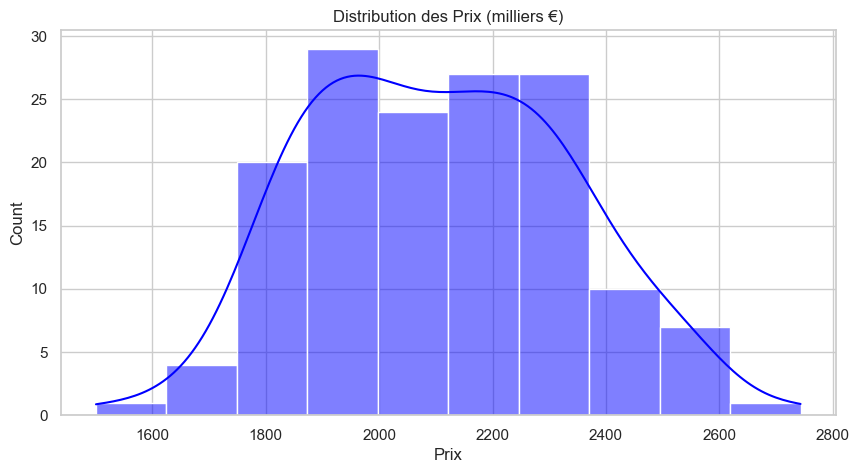

In [4]:
# Visualisation 
# Histogramme du Prix
plt.figure(figsize=(10, 5))
sns.histplot(df['Prix_milliers_euros'], kde=True, color='blue')
plt.title('Distribution des Prix (milliers €)')
plt.xlabel('Prix')
plt.show()


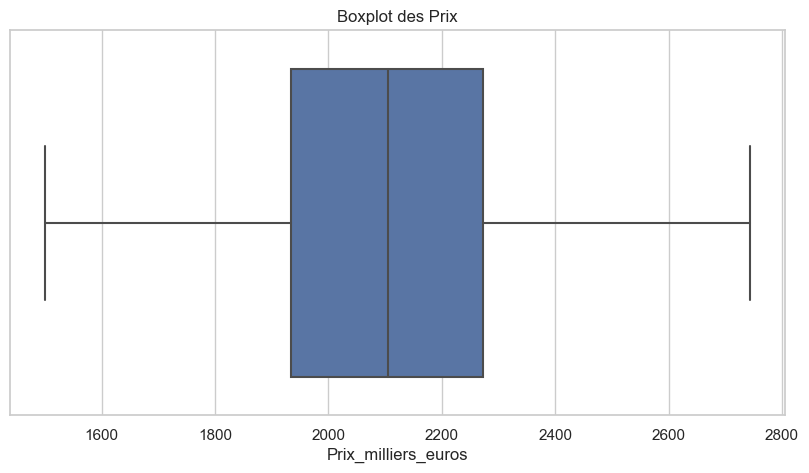

In [5]:
# Boîtes à moustaches (Boxplot) pour identifier les outliers
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['Prix_milliers_euros'])
plt.title('Boxplot des Prix')
plt.show()


In [6]:
print("\n--- 1.2 Analyse de Corrélation --- ")
# Matrice de corrélation
corr_matrix = df.corr()

display(corr_matrix)


--- 1.2 Analyse de Corrélation --- 


,ID,Surface_m2,Chambres,Annee_construction,Distance_centre_km,Etage,Ascenseur,Annee_vente,Qualite_ecole,Revenu_median_quartier,Distance_universite,Prix_milliers_euros
ID,1.000000,0.041265,-0.043645,0.056342,-0.022305,0.101838,-0.158938,0.012962,0.051749,-0.098747,-0.054580,0.031379
Surface_m2,0.041265,1.000000,0.590959,-0.034333,-0.074765,0.061126,-0.062416,0.060417,0.043832,0.013908,-0.088362,0.826731
Chambres,-0.043645,0.590959,1.000000,0.039398,-0.102319,0.048986,-0.014694,0.036140,-0.012775,0.011761,-0.089609,0.614825
Annee_construction,0.056342,-0.034333,0.039398,1.000000,-0.088117,-0.044559,-0.100949,-0.055920,-0.009887,0.030304,-0.006250,0.068358
Distance_centre_km,-0.022305,-0.074765,-0.102319,-0.088117,1.000000,0.018235,0.082010,0.076058,0.042029,0.111579,-0.055751,-0.306648
Etage,0.101838,0.061126,0.048986,-0.044559,0.018235,1.000000,-0.076326,0.126383,-0.031142,0.038186,0.077101,0.128403
Ascenseur,-0.158938,-0.062416,-0.014694,-0.100949,0.082010,-0.076326,1.000000,-0.081879,0.058634,0.082165,-0.061314,0.038303
Annee_vente,0.012962,0.060417,0.036140,-0.055920,0.076058,0.126383,-0.081879,1.000000,0.020798,0.007267,0.033378,0.236992
Qualite_ecole,0.051749,0.043832,-0.012775,-0.009887,0.042029,-0.031142,0.058634,0.020798,1.000000,0.598651,-0.444083,0.253632
Revenu_median_quartier,-0.098747,0.013908,0.011761,0.030304,0.111579,0.038186,0.082165,0.007267,0.598651,1.000000,-0.304002,0.205779


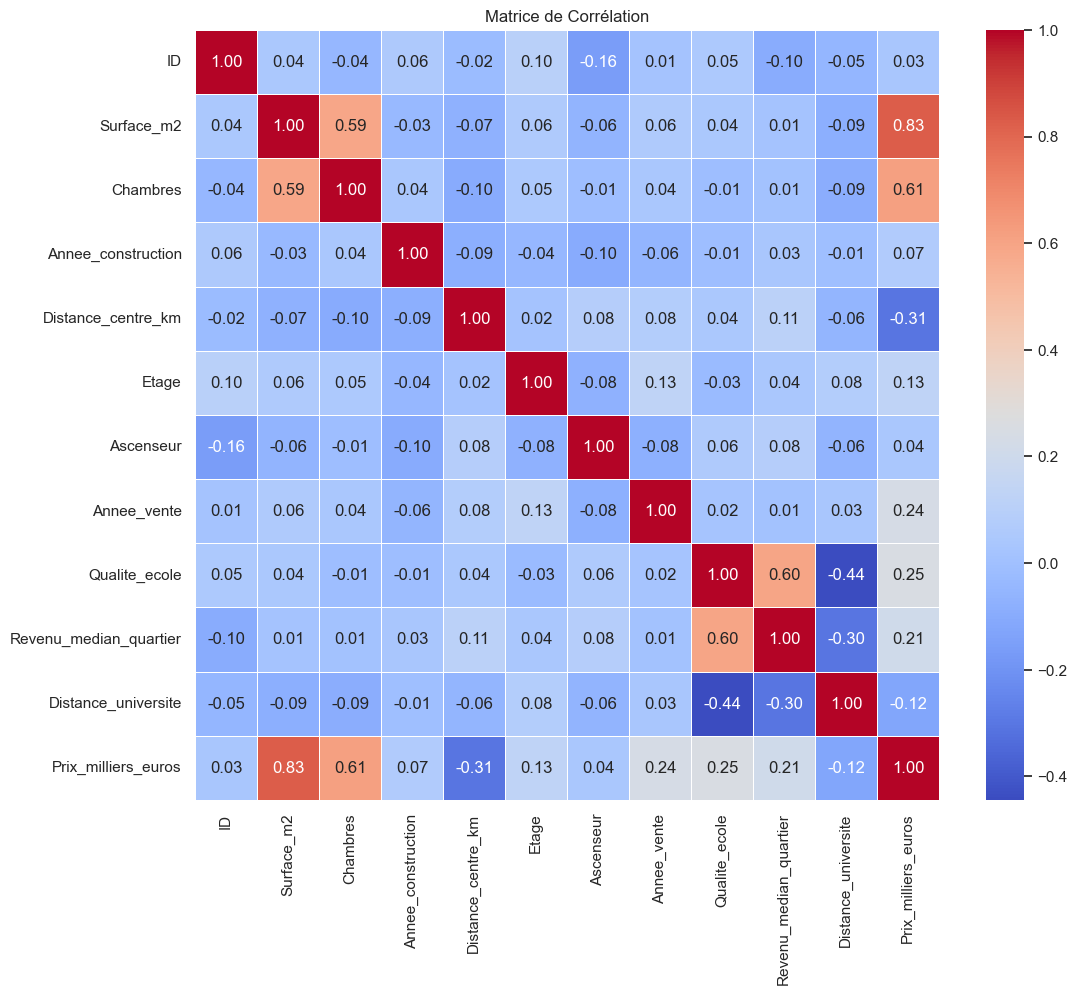

In [7]:
# Heatmap 
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matrice de Corrélation')
plt.show()


In [8]:
# Identification des fortes corrélations
print("Paires fortement corrélées (> 0.7 ou < -0.7) :")
stack = corr_matrix.unstack()
high_corr = stack[(abs(stack) > 0.7) & (abs(stack) < 1)].drop_duplicates()
print(high_corr)

Paires fortement corrélées (> 0.7 ou < -0.7) :
Surface_m2  Prix_milliers_euros    0.826731
dtype: float64


In [9]:
# ==============================================================================
# 2. LE MODÈLE LINÉAIRE 
# ==============================================================================
print("\n--- 2.1 Régression Simple (Prix ~ Surface) --- ")
# Modèle OLS simple
model_simple = smf.ols('Prix_milliers_euros ~ Surface_m2', data=df).fit()
print(model_simple.summary())



--- 2.1 Régression Simple (Prix ~ Surface) --- 
                             OLS Regression Results                            
Dep. Variable:     Prix_milliers_euros   R-squared:                       0.683
Model:                             OLS   Adj. R-squared:                  0.681
Method:                  Least Squares   F-statistic:                     319.6
Date:                 Fri, 26 Dec 2025   Prob (F-statistic):           8.45e-39
Time:                         20:48:24   Log-Likelihood:                -941.72
No. Observations:                  150   AIC:                             1887.
Df Residuals:                      148   BIC:                             1893.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

In [10]:
print("\n--- 2.2 Régression Multiple ---")
# Définition des variables explicatives selon l'énoncé 
formula_multi = ('Prix_milliers_euros ~ Surface_m2 + Chambres + Annee_construction + '
                 'Distance_centre_km + Etage + Ascenseur')
model_multi = smf.ols(formula_multi, data=df).fit()
print(model_multi.summary())



--- 2.2 Régression Multiple ---
                             OLS Regression Results                            
Dep. Variable:     Prix_milliers_euros   R-squared:                       0.789
Model:                             OLS   Adj. R-squared:                  0.780
Method:                  Least Squares   F-statistic:                     88.94
Date:                 Fri, 26 Dec 2025   Prob (F-statistic):           9.10e-46
Time:                         20:48:24   Log-Likelihood:                -911.43
No. Observations:                  150   AIC:                             1837.
Df Residuals:                      143   BIC:                             1858.
Df Model:                            6                                         
Covariance Type:             nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

In [11]:
print("\n--- 2.3 Transformation Logarithmique --- ")

# Modèle Semi-log (Log-Lin): log(Y) ~ X
formula_semilog = ('np.log(Prix_milliers_euros) ~ Surface_m2 + Chambres + Annee_construction + '
                   'Distance_centre_km + Etage + Ascenseur')
model_semilog = smf.ols(formula_semilog, data=df).fit()
print(model_semilog.summary())



--- 2.3 Transformation Logarithmique --- 
                                 OLS Regression Results                                
Dep. Variable:     np.log(Prix_milliers_euros)   R-squared:                       0.792
Model:                                     OLS   Adj. R-squared:                  0.783
Method:                          Least Squares   F-statistic:                     90.56
Date:                         Fri, 26 Dec 2025   Prob (F-statistic):           3.31e-46
Time:                                 20:48:24   Log-Likelihood:                 237.10
No. Observations:                          150   AIC:                            -460.2
Df Residuals:                              143   BIC:                            -439.1
Df Model:                                    6                                         
Covariance Type:                     nonrobust                                         
                         coef    std err          t      P>|t|      [0.025   

In [12]:
# Modèle Log-Log: log(Y) ~ log(X)
# Attention: On ne passe en log que les variables strictement positives et continues pertinentess
# Pour l'année, c'est discutable, mais souvent on garde l'année telle quelle ou on crée un "âge".
# Ici on suit l'énoncé général "log-log".
formula_loglog = ('np.log(Prix_milliers_euros) ~ np.log(Surface_m2) + Chambres + Annee_construction + '
                  'np.log(Distance_centre_km) + Etage + Ascenseur')
model_loglog = smf.ols(formula_loglog, data=df).fit()

print(model_loglog.summary())

                                 OLS Regression Results                                
Dep. Variable:     np.log(Prix_milliers_euros)   R-squared:                       0.755
Model:                                     OLS   Adj. R-squared:                  0.744
Method:                          Least Squares   F-statistic:                     73.29
Date:                         Fri, 26 Dec 2025   Prob (F-statistic):           3.63e-41
Time:                                 20:48:24   Log-Likelihood:                 224.82
No. Observations:                          150   AIC:                            -435.6
Df Residuals:                              143   BIC:                            -414.6
Df Model:                                    6                                         
Covariance Type:                     nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------

In [13]:
# Comparaison rapide (AIC/BIC/R2)
print(f"R2 Simple: {model_multi.rsquared:.4f}, AIC: {model_multi.aic:.2f}")
print(f"R2 Semi-log: {model_semilog.rsquared:.4f}, AIC: {model_semilog.aic:.2f}")
print(f"R2 Log-log: {model_loglog.rsquared:.4f}, AIC: {model_loglog.aic:.2f}")
print("Note: Pour comparer les AIC, la variable dépendante doit être la même (transformée).")

R2 Simple: 0.7887, AIC: 1836.86
R2 Semi-log: 0.7916, AIC: -460.19
R2 Log-log: 0.7546, AIC: -435.65
Note: Pour comparer les AIC, la variable dépendante doit être la même (transformée).


In [14]:
# ==============================================================================
# 3. DIAGNOSTICS DU MODÈLE 
# ==============================================================================
print("\n--- 3.1 Multicolinéarité (VIF) --- ")

# Préparation des données pour VIF (il faut ajouter une constante manuellement)
X_variables = df[['Surface_m2', 'Chambres', 'Annee_construction', 
                  'Distance_centre_km', 'Etage', 'Ascenseur']]
X_with_const = sm.add_constant(X_variables)

vif_data = pd.DataFrame()
vif_data["Variable"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) 
                   for i in range(X_with_const.shape[1])]

print(vif_data)

# Interprétation automatique basique
print("\nCheck rapide VIF > 10 (Seuil critique usuel) :")
print(vif_data[vif_data["VIF"] > 10])


--- 3.1 Multicolinéarité (VIF) --- 
             Variable           VIF
0               const  30387.380900
1          Surface_m2      1.555201
2            Chambres      1.555268
3  Annee_construction      1.026917
4  Distance_centre_km      1.024389
5               Etage      1.012863
6           Ascenseur      1.027848

Check rapide VIF > 10 (Seuil critique usuel) :
  Variable         VIF
0    const  30387.3809


In [15]:
# ==============================================================================
# 4. TESTS ET INFÉRENCE
# ==============================================================================
print("\n" + "="*50)
print("PARTIE 4 : TESTS ET INFÉRENCE")
print("="*50)

# Définition du modèle de base (sans les variables 'Qualite_ecole' et 'Revenu' pour l'instant)
vars_base = ['Surface_m2', 'Chambres', 'Annee_construction', 'Distance_centre_km', 'Etage', 'Ascenseur']
formula_base = 'Prix_milliers_euros ~ ' + ' + '.join(vars_base)
model_base = smf.ols(formula_base, data=df).fit()

# Modele restreint qui nous permettra la construction du modèle emboité pour tester la pertinence
# d'ajoiut des variables supplementaires pour un model complet.


PARTIE 4 : TESTS ET INFÉRENCE


In [16]:
# ---------------------------------------------------------
# 4.1.1 Test Unilatéral : Distance a un effet négatif ? 
# H0: beta_distance >= 0  vs  H1: beta_distance < 0
# ---------------------------------------------------------
coef_dist = model_base.params['Distance_centre_km']
pval_dist_bilateral = model_base.pvalues['Distance_centre_km']
t_stat_dist = model_base.tvalues['Distance_centre_km']

print(f"\n--- 1. Test unilatéral sur la Distance ---")
print(f"Coefficient Distance: {coef_dist:.4f}")
print(f"P-value bilatérale (sortie standard): {pval_dist_bilateral:.4f}")

# Calcul P-value unilatérale
if coef_dist < 0:
    pval_unilateral = pval_dist_bilateral / 2
    print(f"P-value unilatérale: {pval_unilateral:.4f}")
    if pval_unilateral < 0.05:
        print("=> REJET de H0. On confirme l'effet négatif significatif.")
    else:
        print("=> Non significatif.")
else:
    print("=> Le coefficient est positif ! L'hypothèse d'un effet négatif est contredite par les données.")



--- 1. Test unilatéral sur la Distance ---
Coefficient Distance: -6.1446
P-value bilatérale (sortie standard): 0.0000
P-value unilatérale: 0.0000
=> REJET de H0. On confirme l'effet négatif significatif.


In [17]:
# ---------------------------------------------------------
# 4.1.2 Test de Fisher (Variables Jointes) 
# ---------------------------------------------------------
print(f"\n--- 2. Test d'amélioration du modèle (Nested F-test) ---")
# Modèle contraint (Restricted) : model_base
# Modèle non-contraint (Unrestricted) : ajout Qualite_ecole et Revenu
formula_full = formula_base + ' + Qualite_ecole + Revenu_median_quartier'
model_full = smf.ols(formula_full, data=df).fit()

# Comparaison F-test
f_test = model_full.compare_f_test(model_base)
print(f"Statistique F: {f_test[0]:.4f}, P-value: {f_test[1]:.4e}")
if f_test[1] < 0.05:
    print("=> L'ajout des variables 'Qualité École' et 'Revenu' améliore significativement le modèle.")
else:
    print("=> L'ajout n'est pas significatif.")



--- 2. Test d'amélioration du modèle (Nested F-test) ---
Statistique F: 28.6616, P-value: 3.5902e-11
=> L'ajout des variables 'Qualité École' et 'Revenu' améliore significativement le modèle.


In [18]:
# ---------------------------------------------------------
# 4.2 Stabilité Structurelle (Test de Chow / COVID) 
# ---------------------------------------------------------
print(f"\n--- 3. Stabilité Structurelle (Effet COVID) ---")
# Création dummy COVID (Vente >= 2020)
df['Post_COVID'] = (df['Annee_vente'] >= 2020).astype(int)

# Modèle avec interactions complètes (Chow Test equivalent)
# Y = a + bX + c*COVID + d*(X*COVID)
# On teste si c et d sont conjointement nuls
formula_chow = f"Prix_milliers_euros ~ ({' + '.join(vars_base)}) * Post_COVID"
model_chow = smf.ols(formula_chow, data=df).fit()

# Identification des termes liés au COVID
hypotheses_chow = [x for x in model_chow.params.index if 'Post_COVID' in x]
chow_test_result = model_chow.f_test(hypotheses_chow)

print(f"Test de Chow (Validité globale des interactions COVID) :")
print(f"F-stat: {chow_test_result.statistic:.4f}, P-value: {chow_test_result.pvalue:.4f}")

if chow_test_result.pvalue < 0.05:
    print("=> Rupture structurelle détectée ! Le marché se comporte différemment après 2020.")
    print("=> Recommandation : Envisager deux modèles séparés ou garder les interactions.")
else:
    print("=> Pas de rupture structurelle significative détectée.")



--- 3. Stabilité Structurelle (Effet COVID) ---
Test de Chow (Validité globale des interactions COVID) :
F-stat: 7.2758, P-value: 0.0000
=> Rupture structurelle détectée ! Le marché se comporte différemment après 2020.
=> Recommandation : Envisager deux modèles séparés ou garder les interactions.



PARTIE 5 : HÉTÉROSCÉDASTICITÉ ET AUTOCORRÉLATION


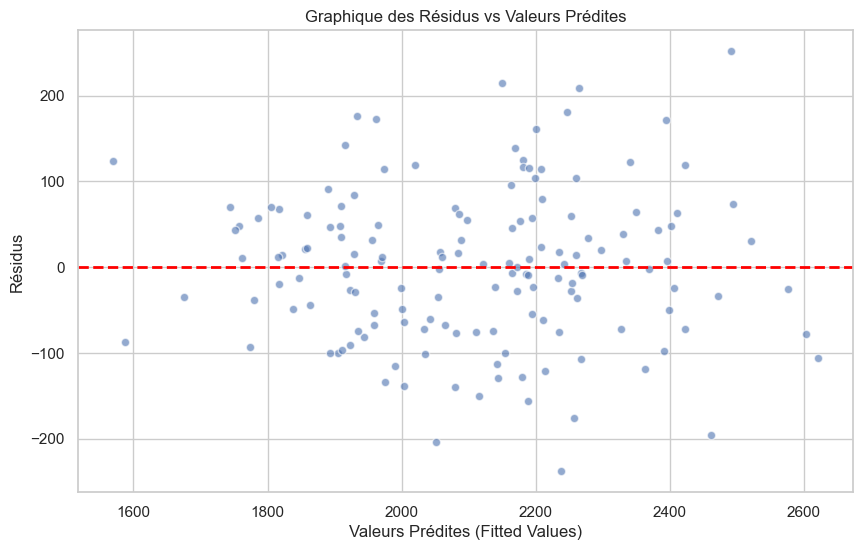

In [19]:
# ==============================================================================
# 5. HÉTÉROSCÉDASTICITÉ ET AUTOCORRÉLATION
# ==============================================================================
print("\n" + "="*50)
print("PARTIE 5 : HÉTÉROSCÉDASTICITÉ ET AUTOCORRÉLATION")
print("="*50)

# On utilise le 'model_full' (le meilleur modèle identifié plus haut) pour les diagnostics
residuals = model_full.resid
fitted = model_full.fittedvalues

# ---------------------------------------------------------
# 5.1.1 Analyse Graphique
# ---------------------------------------------------------
plt.figure(figsize=(10, 6))
plt.scatter(fitted, residuals, alpha=0.6, edgecolors='w')
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Valeurs Prédites (Fitted Values)')
plt.ylabel('Résidus')
plt.title('Graphique des Résidus vs Valeurs Prédites')
plt.show() # 


In [20]:
# ---------------------------------------------------------
# 5.1.2 Test Hétéroscédasticité (Breusch-Pagan)
# ---------------------------------------------------------
print(f"\n--- 1. Test de Breusch-Pagan ---")
bp_test = het_breuschpagan(residuals, model_full.model.exog)
bp_pval = bp_test[1]
print(f"LM Statistic: {bp_test[0]:.4f}, P-value: {bp_pval:.4e}")

if bp_pval < 0.05:
    print("=> HÉTÉROSCÉDASTICITÉ DÉTECTÉE (P-value < 0.05)")
    correction_needed = True
else:
    print("=> Homoscédasticité acceptée (Variance des erreurs constante).")
    correction_needed = False



--- 1. Test de Breusch-Pagan ---
LM Statistic: 11.9951, P-value: 1.5142e-01
=> Homoscédasticité acceptée (Variance des erreurs constante).


In [21]:
# On reprend les résidus et les variables du modèle complet
residuals = model_full.resid
exog = model_full.model.exog

print("\n--- Test de White (Hétéroscédasticité Générale) ---")
# Le test de White retourne 4 valeurs : LM stat, LM p-value, F stat, F p-value
white_test = het_white(residuals, exog)

print(f"LM Statistic: {white_test[0]:.4f}")
print(f"LM P-value:   {white_test[1]:.4e}")
print(f"F Statistic:  {white_test[2]:.4f}")
print(f"F P-value:    {white_test[3]:.4e}")

if white_test[1] < 0.05:
    print("=> Hétéroscédasticité détectée par White (Rejet de H0).")
    print("   Cela confirme la nécessité d'utiliser des écarts-types robustes (HC3) ou WLS.")
else:
    print("=> Pas d'hétéroscédasticité détectée par White.")


--- Test de White (Hétéroscédasticité Générale) ---
LM Statistic: 43.1591
LM P-value:   4.6451e-01
F Statistic:  0.9958
F P-value:    4.9213e-01
=> Pas d'hétéroscédasticité détectée par White.


In [22]:
# ---------------------------------------------------------
# 5.1.3 Comparaison MCO, MCO-Robuste, WLS 
# ---------------------------------------------------------
print(f"\n--- 2. Comparaison des corrections ---")

# A. MCO Standard
print("A. MCO Standard (Erreurs-types biaisés si Hétéro):")
print(model_full.bse.head(3)) # On affiche juste les 3 premiers SE pour comparer

# B. MCO Robuste (HC3 - White)
model_robust = model_full.get_robustcov_results(cov_type='HC3')
print("\nB. MCO Robuste (HC3):")
print(model_robust.bse[:3])

# C. WLS (Weighted Least Squares - Feasible GLS)
# Pour faire WLS, on doit estimer les poids.
# Méthode : Regresser log(resid^2) sur les variables, prédire la variance, pondérer par 1/variance.
log_resid_sq = np.log(residuals**2)
model_var = smf.ols(f"log_resid_sq ~ {' + '.join(model_full.model.exog_names[1:])}", 
                    data=df.assign(log_resid_sq=log_resid_sq)).fit()
weights = 1 / np.exp(model_var.fittedvalues)

model_wls = smf.wls(formula_full, data=df, weights=weights).fit()
print("\nC. WLS (Moindres Carrés Pondérés):")
print(model_wls.bse.head(3))
print("Note: WLS est plus efficace (plus petits écarts-types) que MCO Robuste SI la forme de l'hétéroscédasticité est bien spécifiée.")




--- 2. Comparaison des corrections ---
A. MCO Standard (Erreurs-types biaisés si Hétéro):
Intercept     1304.551005
Surface_m2       0.249028
Chambres         8.701953
dtype: float64

B. MCO Robuste (HC3):
[1.43576173e+03 2.69460976e-01 8.99562398e+00]

C. WLS (Moindres Carrés Pondérés):
Intercept     1281.822644
Surface_m2       0.237314
Chambres         8.515981
dtype: float64
Note: WLS est plus efficace (plus petits écarts-types) que MCO Robuste SI la forme de l'hétéroscédasticité est bien spécifiée.


In [23]:
# ---------------------------------------------------------
# 5.2 Autocorrélation
# ---------------------------------------------------------
print(f"\n--- 3. Autocorrélation ---")
dw_stat = durbin_watson(residuals)
print(f"Statistique Durbin-Watson: {dw_stat:.2f}")

if dw_stat < 1.5 or dw_stat > 2.5:
    print("=> Risque d'Autocorrélation (loin de 2).")
    autocorr_detected = True
else:
    print("=> Pas d'autocorrélation évidente (proche de 2).")
    autocorr_detected = False

# Correction Newey-West (HAC) si double problème [cite: 99]
if correction_needed or autocorr_detected:
    print("\n--- Correction Finale : Newey-West (HAC) ---")
    print("Robuste à la fois à l'hétéroscédasticité et à l'autocorrélation.")
    # maxlags=1 est une convention simple pour données annuelles courtes
    model_nw = model_full.get_robustcov_results(cov_type='HAC', use_t=True, maxlags=1)
    print(model_nw.summary().tables[1])


--- 3. Autocorrélation ---
Statistique Durbin-Watson: 2.32
=> Pas d'autocorrélation évidente (proche de 2).


In [24]:
print("\n" + "="*50)
print("PARTIE 6 : ENDOGÉNÉITÉ ET VARIABLES INSTRUMENTALES")
print("="*50)

# ---------------------------------------------------------
# Préparation des variables
# ---------------------------------------------------------
# On suppose que 'df' est votre dataframe chargé
# Variables Exogènes (Contrôles) : Tout ce qui n'est PAS l'école
exog_vars = ['const', 'Surface_m2', 'Chambres', 'Annee_construction', 
             'Distance_centre_km', 'Etage', 'Ascenseur', 'Revenu_median_quartier']

# Ajout de la constante (obligatoire pour linearmodels)
df = sm.add_constant(df)


PARTIE 6 : ENDOGÉNÉITÉ ET VARIABLES INSTRUMENTALES


In [25]:
# ---------------------------------------------------------
# Étape 1 : Vérification de la Pertinence de l'Instrument (First Stage)
# On régresse l'Endogène (Ecole) sur l'Instrument (Univ) + les Contrôles
# ---------------------------------------------------------
print("\n--- 1. Première Étape (First Stage) ---")
# Formule : Qualite_ecole ~ Distance_universite + Contrôles
formula_fs = 'Qualite_ecole ~ Distance_universite + Surface_m2 + Chambres + Annee_construction + Distance_centre_km + Etage + Ascenseur + Revenu_median_quartier'
model_fs = sm.OLS.from_formula(formula_fs, data=df).fit()

print(f"Coefficient Instrument (Distance_Univ): {model_fs.params['Distance_universite']:.4f}")
print(f"P-value Instrument: {model_fs.pvalues['Distance_universite']:.4e}")

# Test F de la première étape (Rule of Thumb : Doit être > 10)
# On teste l'hypothèse nulle que le coeff de l'instrument est 0
f_test_fs = model_fs.f_test("Distance_universite = 0")
f_stat_val = f_test_fs.statistic
print(f"F-statistic (First Stage): {f_stat_val:.2f}")

if f_stat_val > 10:
    print("=> Instrument FORT (F > 10). On peut procéder.")
else:
    print("=> Instrument FAIBLE (F < 10). Risque de biais dans la 2ème étape.")



--- 1. Première Étape (First Stage) ---
Coefficient Instrument (Distance_Univ): -0.1442
P-value Instrument: 2.8586e-05
F-statistic (First Stage): 18.71
=> Instrument FORT (F > 10). On peut procéder.


In [26]:
# ---------------------------------------------------------
# Étape 2 : Estimation IV (2SLS) avec linearmodels
# ---------------------------------------------------------
print("\n--- 2. Estimation IV (2SLS) ---")

# Syntaxe IV2SLS(Dependent, Exog, Endog, Instruments)
iv_model = IV2SLS(dependent=df['Prix_milliers_euros'],
                  exog=df[exog_vars],
                  endog=df['Qualite_ecole'],
                  instruments=df['Distance_universite'])

res_iv = iv_model.fit(cov_type='robust') # Erreurs robustes
print(res_iv.summary)



--- 2. Estimation IV (2SLS) ---
                           IV-2SLS Estimation Summary                          
Dep. Variable:     Prix_milliers_euros   R-squared:                      0.8299
Estimator:                     IV-2SLS   Adj. R-squared:                 0.8202
No. Observations:                  150   F-statistic:                    892.14
Date:                 Fri, Dec 26 2025   P-value (F-stat)                0.0000
Time:                         20:48:24   Distribution:                  chi2(8)
Cov. Estimator:                 robust                                         
                                                                               
                                   Parameter Estimates                                    
                        Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------------
const                     -1563.4     1377.7    -1.134

In [27]:
# ---------------------------------------------------------
# 6.2.4 Comparaison MCO vs IV 
# ---------------------------------------------------------
print("\n--- 3. Comparaison MCO vs IV ---")

# On ré-estime le MCO complet pour comparer
model_mco_final = sm.OLS(df['Prix_milliers_euros'], 
                         df[exog_vars + ['Qualite_ecole']]).fit()

coef_school_mco = model_mco_final.params['Qualite_ecole']
coef_school_iv = res_iv.params['Qualite_ecole']

print(f"Coeff Ecole (MCO) : {coef_school_mco:.4f}")
print(f"Coeff Ecole (IV)  : {coef_school_iv:.4f}")

diff_rel = (coef_school_iv - coef_school_mco) / coef_school_mco * 100
print(f"Différence relative : {diff_rel:.2f}%")

if abs(diff_rel) > 20:
    print("=> Différence importante. L'endogénéité biaisait significativement les résultats MCO.")
    if coef_school_iv < coef_school_mco:
         print("   (Le biais MCO était probablement positif : on surestimait l'effet de l'école).")
else:
    print("=> Peu de différence. L'endogénéité n'est peut-être pas un problème majeur ici.")

# Test de Wu-Hausman (automatiquement fourni par linearmodels dans le summary)
# Affichage explicite du test d'endogénéité (Wu-Hausman)
print("\n--- Test d'Endogénéité (Wu-Hausman) ---")
# Ce test vérifie H0 : La variable est exogène (OLS est valide et meilleur)
# H1 : La variable est endogène (OLS biaisé, il faut utiliser IV)
print(res_iv.wu_hausman())

print("Si P-value < 0.05 => On rejette l'égalité MCO/IV => Il FAUT utiliser l'IV.")

# Note sur le test de Sargan (Validité des instruments)
print("\n--- Test de Sargan (Sur-identification) ---")
if res_iv.sargan is not None:
    print(res_iv.sargan)
else:
    print("Le test de Sargan n'est pas disponible car le modèle est 'juste-identifié'")
    print("(Nombre d'instruments = Nombre de variables endogènes)")



--- 3. Comparaison MCO vs IV ---
Coeff Ecole (MCO) : 20.8434
Coeff Ecole (IV)  : -0.9417
Différence relative : -104.52%
=> Différence importante. L'endogénéité biaisait significativement les résultats MCO.
   (Le biais MCO était probablement positif : on surestimait l'effet de l'école).

--- Test d'Endogénéité (Wu-Hausman) ---
Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 2.4975
P-value: 0.1163
Distributed: F(1,140)
Si P-value < 0.05 => On rejette l'égalité MCO/IV => Il FAUT utiliser l'IV.

--- Test de Sargan (Sur-identification) ---
Invalid test statistic
Test requires more instruments than endogenous variables.
Sargan's test of overidentification


In [28]:
print("\n" + "="*50)
print("PARTIE 7 : RÉGULARISATION (RIDGE & LASSO)")
print("="*50)

# 1. Préparation des données 
# On utilise toutes les variables disponibles pour voir la puissance de la sélection
features = ['Surface_m2', 'Chambres', 'Annee_construction', 'Distance_centre_km', 
            'Etage', 'Ascenseur', 'Revenu_median_quartier', 'Qualite_ecole']
            # Ajouter 'Distance_universite' si elle est dans votre df

# Vérification que les colonnes existent
X = df[features]
y = df['Prix_milliers_euros']



PARTIE 7 : RÉGULARISATION (RIDGE & LASSO)


In [29]:
# 2. Division Train / Test (80% - 20%) [cite: 122]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [30]:
# 3. Standardisation (CRUCIAL) 
# On fit sur le TRAIN et on transforme le TEST (pour éviter le data leakage)
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=features)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=features)


Génération des graphiques d'évolution des coefficients...


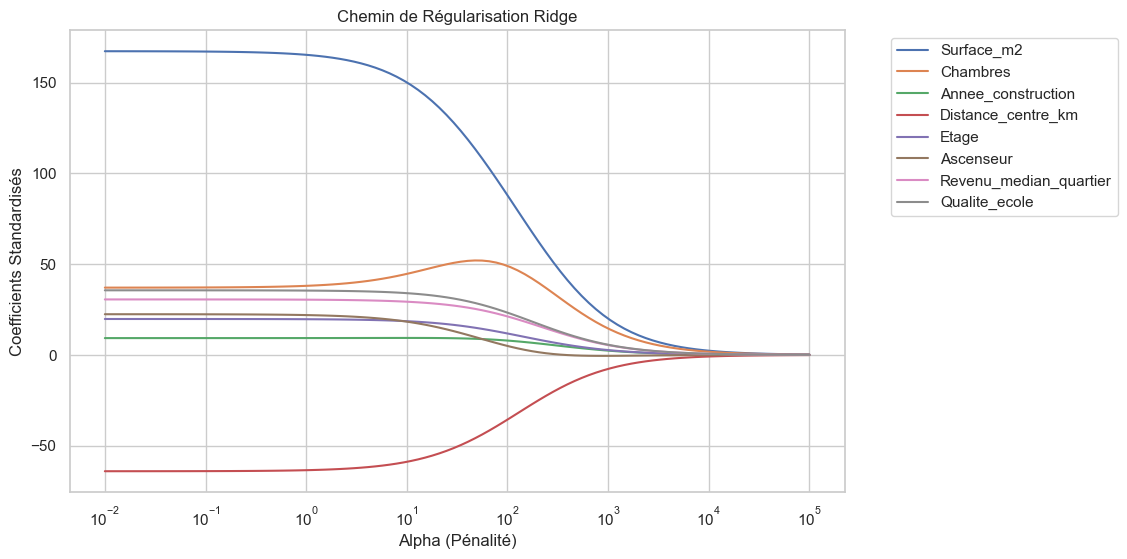

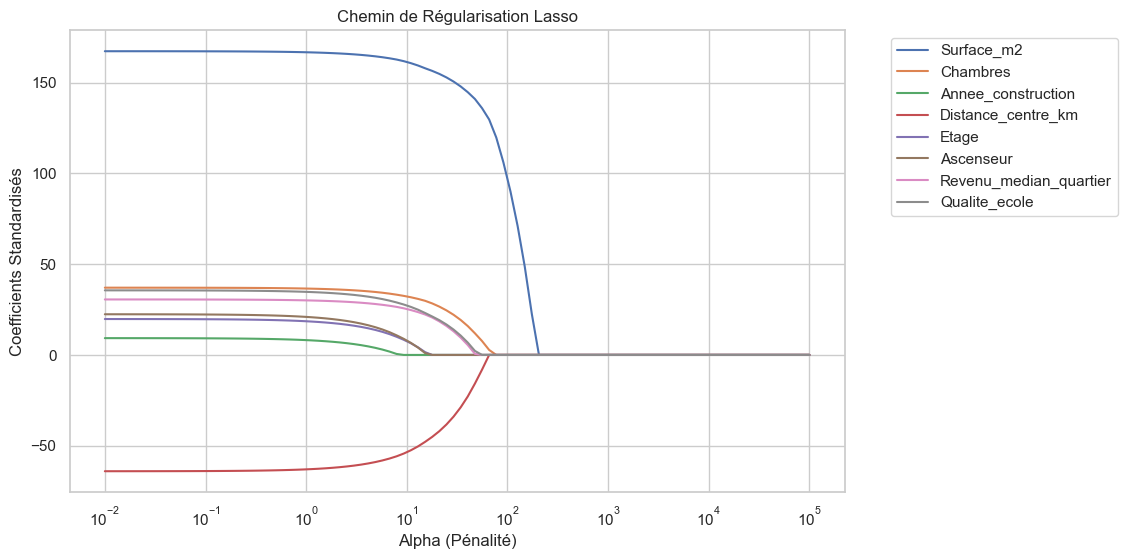

In [31]:
# ==============================================================================
# ANALYSE DE L'ÉVOLUTION DES COEFFICIENTS (Chemin de Régularisation)
# ==============================================================================
# Cette section génère les graphiques demandés pour "analyser l'évolution"

def plot_regularization_path(model_class, model_name, alphas):
    coefs = []
    for a in alphas:
        model = model_class(alpha=a)
        model.fit(X_train_scaled, y_train)
        coefs.append(model.coef_)
    
    plt.figure(figsize=(10, 6))
    ax = plt.gca()
    ax.plot(alphas, coefs)
    ax.set_xscale('log') # Echelle log pour alpha car on teste de 0.01 à 10000
    plt.xlabel('Alpha (Pénalité)')
    plt.ylabel('Coefficients Standardisés')
    plt.title(f'Chemin de Régularisation {model_name}')
    plt.axis('tight')
    plt.legend(features, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

# Définition d'une grille d'alphas large
alphas_range = np.logspace(-2, 5, 100) # De 0.01 à 100,000

print("Génération des graphiques d'évolution des coefficients...")
plot_regularization_path(Ridge, "Ridge", alphas_range)
plot_regularization_path(Lasso, "Lasso", alphas_range)
# Interprétation : 
# Ridge : Les coeffs tendent vers 0 sans jamais l'atteindre.
# Lasso : Les coeffs tombent à 0 les uns après les autres (sélection de variables).


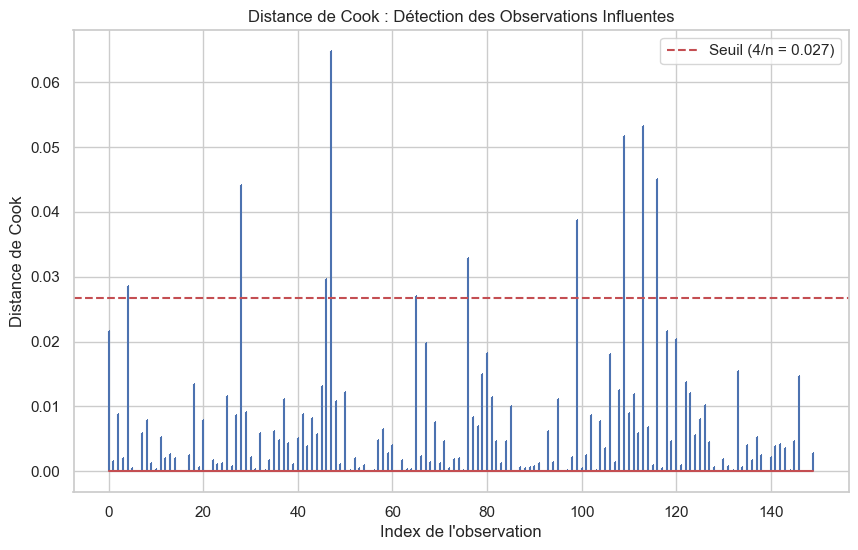

In [38]:
# Supposons que 'model' est votre modèle OLS final (celui avec toutes les variables)
# influence = model.get_influence()

# Récupération de la distance de Cook
infl = model_multi.get_influence()
(c, p) = infl.cooks_distance

# Création du graphique
plt.figure(figsize=(10, 6))
plt.stem(np.arange(len(c)), c, markerfmt=",")
plt.title("Distance de Cook : Détection des Observations Influentes")
plt.xlabel("Index de l'observation")
plt.ylabel("Distance de Cook")

# Seuil indicatif (4/n)
seuil = 4 / len(df)
plt.axhline(seuil, color='r', linestyle='--', label=f'Seuil (4/n = {seuil:.3f})')
plt.legend()

# Sauvegarde pour le rapport LaTeX
plt.savefig('cooks_distance.png')
plt.show()

In [40]:
###### ==============================================================================
# OPTIMISATION (Validation Croisée 10-fold) 
# ==============================================================================
print("\n--- Recherche des paramètres optimaux (Cross-Validation) ---")

# Ridge avec CV intégrée
ridge_cv = RidgeCV(alphas=alphas_range, cv=10, scoring='neg_root_mean_squared_error')
ridge_cv.fit(X_train_scaled, y_train)
best_alpha_ridge = ridge_cv.alpha_
print(f"Meilleur Alpha Ridge : {best_alpha_ridge:.4f}")

# Lasso avec CV intégrée
lasso_cv = LassoCV(cv=10, random_state=42, max_iter=10000)
lasso_cv.fit(X_train_scaled, y_train)
best_alpha_lasso = lasso_cv.alpha_
print(f"Meilleur Alpha Lasso : {best_alpha_lasso:.4f}")



--- Recherche des paramètres optimaux (Cross-Validation) ---
Meilleur Alpha Ridge : 1.3219
Meilleur Alpha Lasso : 0.1973


In [33]:
# ==============================================================================
# COMPARAISON DES PERFORMANCES (RMSE sur Test) [cite: 121-122]
# ==============================================================================
print("\n--- Comparaison des Performances (RMSE sur Test Set) ---")

# 1. Modèle OLS (Référence)
ols = LinearRegression()
ols.fit(X_train_scaled, y_train)
y_pred_ols = ols.predict(X_test_scaled)
rmse_ols = np.sqrt(mean_squared_error(y_test, y_pred_ols))

# 2. Modèle Ridge Optimal
ridge_opt = Ridge(alpha=best_alpha_ridge)
ridge_opt.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_opt.predict(X_test_scaled)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))

# 3. Modèle Lasso Optimal
lasso_opt = Lasso(alpha=best_alpha_lasso)
lasso_opt.fit(X_train_scaled, y_train)
y_pred_lasso = lasso_opt.predict(X_test_scaled)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))

# Affichage des résultats
results_df = pd.DataFrame({
    'Modèle': ['OLS Classique', 'Ridge (L2)', 'Lasso (L1)'],
    'RMSE': [rmse_ols, rmse_ridge, rmse_lasso],
    'Alpha Optimal': [0, best_alpha_ridge, best_alpha_lasso]
})

print(results_df)



--- Comparaison des Performances (RMSE sur Test Set) ---
          Modèle       RMSE  Alpha Optimal
0  OLS Classique  93.097760       0.000000
1     Ridge (L2)  92.351016       1.321941
2     Lasso (L1)  93.113112       0.197258


In [34]:
# ==============================================================================
# ANALYSE DES COEFFICIENTS LASSO (Sélection de variables)
# ==============================================================================
print("\n--- Coefficients retenus par le Lasso Optimal ---")
coef_lasso_df = pd.Series(lasso_opt.coef_, index=features)
print(coef_lasso_df)
print("\nVariables éliminées (Coeff = 0) :")
print(coef_lasso_df[coef_lasso_df == 0].index.tolist())


--- Coefficients retenus par le Lasso Optimal ---
Surface_m2                167.278212
Chambres                   36.976079
Annee_construction          9.049859
Distance_centre_km        -63.898361
Etage                      19.552781
Ascenseur                  22.141367
Revenu_median_quartier     30.484775
Qualite_ecole              35.434915
dtype: float64

Variables éliminées (Coeff = 0) :
[]


In [35]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

print("\n" + "="*50)
print("PARTIE 8 : PRÉVISIONS")
print("="*50)

# 1. Définition du profil de la maison 
# Attention aux unités ! (Revenu en milliers, pas en euros bruts)
maison_profil = {
    'Surface_m2': [120],            
    'Chambres': [3],                
    'Annee_construction': [2015],   
    'Distance_centre_km': [5],      
    'Etage': [1],                   
    'Ascenseur': [1],               
    'Annee_vente': [2023],          
    'Qualite_ecole': [7],           
    'Revenu_median_quartier': [65], 
    'Distance_universite': [4]      
}

# Conversion en DataFrame
df_new = pd.DataFrame(maison_profil)

# Ajout de la constante (nécessaire pour statsmodels)
df_new = sm.add_constant(df_new, has_constant='add')

print("Profil de la maison à estimer :")
print(df_new.iloc[0])



PARTIE 8 : PRÉVISIONS
Profil de la maison à estimer :
const                        1.0
Surface_m2                 120.0
Chambres                     3.0
Annee_construction        2015.0
Distance_centre_km           5.0
Etage                        1.0
Ascenseur                    1.0
Annee_vente               2023.0
Qualite_ecole                7.0
Revenu_median_quartier      65.0
Distance_universite          4.0
Name: 0, dtype: float64


In [36]:
# 2. Choix du modèle pour la prédiction
# Nous utilisons 'model_full' (OLS avec toutes les variables) défini en Partie 4.
# C'est généralement le plus fiable pour l'inférence standard.
# (Assurez-vous que model_full a été exécuté dans les blocs précédents)

try:
    # L'objet prediction de statsmodels calcule automatiquement les intervalles
    prediction = model_full.get_prediction(df_new)
    pred_summary = prediction.summary_frame(alpha=0.05) # Alpha 0.05 = 95% confiance

    # Extraction des valeurs
    prix_estime = pred_summary['mean'][0]
    ci_lower = pred_summary['mean_ci_lower'][0]
    ci_upper = pred_summary['mean_ci_upper'][0]
    
    # Note technique : Ceci est l'intervalle de confiance de la MOYENNE.
    # Pour l'intervalle de prédiction d'une OBSERVATION INDIVIDUELLE (plus large),
    # on utiliserait 'obs_ci_lower' et 'obs_ci_upper'.
    # L'énoncé demande "l'intervalle de confiance"[cite: 142], donc on donne mean_ci.

    print(f"\n--- RÉSULTATS DE LA PRÉDICTION ---")
    print(f"Prix estimé (Ponctuel) : {prix_estime:.2f} k€")
    print(f"Intervalle de Confiance (95%) : [{ci_lower:.2f} k€, {ci_upper:.2f} k€]")

except NameError:
    print("Erreur : 'model_full' n'est pas défini. Veuillez relancer le code de la Partie 4.")



--- RÉSULTATS DE LA PRÉDICTION ---
Prix estimé (Ponctuel) : 2263.12 k€
Intervalle de Confiance (95%) : [2224.93 k€, 2301.32 k€]


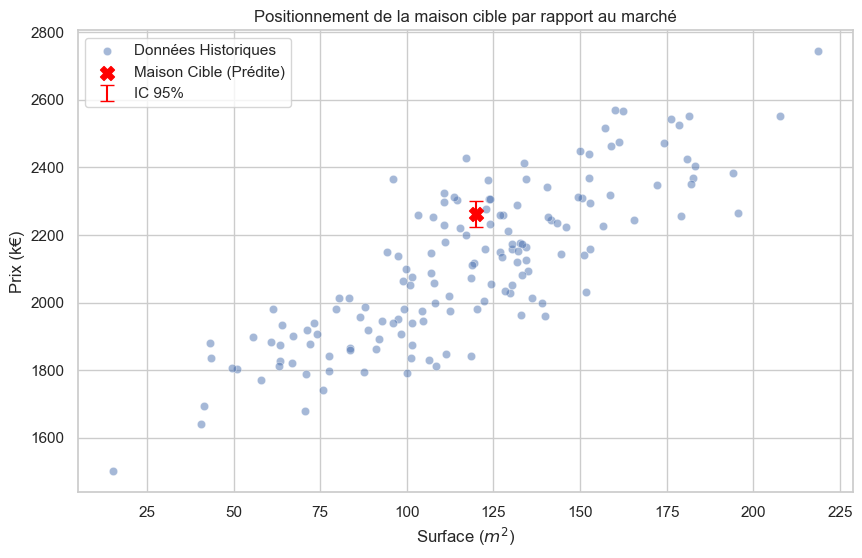

In [37]:
# 3. Visualisation de la prédiction dans le contexte des données
# On trace Prix vs Surface et on place notre nouvelle maison
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['Surface_m2'], y=df['Prix_milliers_euros'], alpha=0.5, label='Données Historiques')

# Ajout du point prédit
plt.scatter(df_new['Surface_m2'], prix_estime, color='red', s=100, marker='X', label='Maison Cible (Prédite)')
# Ajout de la barre d'erreur (Intervalle de confiance)
plt.errorbar(df_new['Surface_m2'], prix_estime, 
             yerr=[[prix_estime - ci_lower], [ci_upper - prix_estime]], 
             fmt='none', ecolor='red', capsize=5, label='IC 95%')

plt.title('Positionnement de la maison cible par rapport au marché')
plt.xlabel('Surface ($m^2$)')
plt.ylabel('Prix (k€)')
plt.legend()
plt.show()